In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML

In [3]:
# 데이터 로드, 날짜 데이터 변환
file_path = "./data/cluster_result.csv"  
dt = pd.read_csv(file_path, sep=',', encoding='utf-8', parse_dates=['DateTime'], infer_datetime_format=True)

C:\Users\doing\AppData\Local\Temp\ipykernel_13432\3297767452.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.read_csv(file_path, sep=',', encoding='utf-8', parse_dates=['DateTime'], infer_datetime_format=True)


In [4]:
# 데이터 확인
print(dt.columns) 
print(dt.head(20))  
print(dt.info())  

Index(['Unnamed: 0', 'DateTime', 'USD', 'Effective Federal Funds Rate',
       'Government Bond 10Y', 'Interbank Rate', 'Interest Rate',
       'Stock Market', 'Auto Exports', 'Average House Prices',
       ...
       'Personal Income Tax Rate', 'Population', 'Precipitation',
       'Private Debt to GDP', 'Retirement Age Men', 'Retirement Age Women',
       'Temperature', 'Terrorism Index', 'Weapons Sales', 'kmeans_label'],
      dtype='object', length=259)
    Unnamed: 0   DateTime     USD  Effective Federal Funds Rate  \
0            0 2005-01-03  435.60                          2.31   
1            1 2005-01-04  427.75                          2.25   
2            2 2005-01-05  426.00                          2.25   
3            3 2005-01-06  424.35                          2.25   
4            4 2005-01-07  422.20                          2.24   
5            5 2005-01-10  420.00                          2.26   
6            6 2005-01-11  421.35                          2.24   
7 

In [5]:
# 불필요한 컬럼 제거 (kmeans_label, Unnamed: 0, DateTime)
dt_cleaned = dt.drop(['kmeans_label', 'Unnamed: 0'], axis=1)

In [6]:
# NaN 값이 포함된 컬럼과 NaN 개수 확인
nan_cnt = dt.isnull().sum()[dt.isnull().sum() > 0]
print("NaN 값이 포함된 컬럼과 NaN 개수:\n", nan_cnt)



NaN 값이 포함된 컬럼과 NaN 개수:
 Interbank Rate                    1
Housing Starts Single Family     21
CO2 Emissions                   260
Hospitals                       520
Hospital Beds                   520
Medical Doctors                 520
Nurses                          260
Precipitation                   260
Temperature                     260
dtype: int64


In [7]:
# NaN 값이 포함된 행 제거
df_cleaned = dt.dropna()

In [8]:
print("NaN 값이 포함된 컬럼 제거 후 컬럼별 NaN 개수:\n", df_cleaned.isnull().sum())

NaN 값이 포함된 컬럼 제거 후 컬럼별 NaN 개수:
 Unnamed: 0                      0
DateTime                        0
USD                             0
Effective Federal Funds Rate    0
Government Bond 10Y             0
                               ..
Retirement Age Women            0
Temperature                     0
Terrorism Index                 0
Weapons Sales                   0
kmeans_label                    0
Length: 259, dtype: int64


In [9]:
# 데이터 확인
print(dt_cleaned.columns) 
print(dt_cleaned.head(20))  
print(dt_cleaned.info())  

Index(['DateTime', 'USD', 'Effective Federal Funds Rate',
       'Government Bond 10Y', 'Interbank Rate', 'Interest Rate',
       'Stock Market', 'Auto Exports', 'Average House Prices',
       'Balance of Trade',
       ...
       'Nurses', 'Personal Income Tax Rate', 'Population', 'Precipitation',
       'Private Debt to GDP', 'Retirement Age Men', 'Retirement Age Women',
       'Temperature', 'Terrorism Index', 'Weapons Sales'],
      dtype='object', length=257)
     DateTime     USD  Effective Federal Funds Rate  Government Bond 10Y  \
0  2005-01-03  435.60                          2.31                4.218   
1  2005-01-04  427.75                          2.25                4.296   
2  2005-01-05  426.00                          2.25                4.285   
3  2005-01-06  424.35                          2.25                4.265   
4  2005-01-07  422.20                          2.24                4.273   
5  2005-01-10  420.00                          2.26                4.275   

In [10]:
# 데이터프레임에서 숫자형 데이터만 선택하여 날짜 컬럼 제외
dt_numeric = dt_cleaned.select_dtypes(include=[np.number])  # 숫자형 데이터만 선택 (날짜 컬럼 제외)

# 데이터 표준화
scaler = StandardScaler()
dt_scaled = scaler.fit_transform(dt_numeric) 

# numpy 배열을 pandas 데이터프레임으로 변환
df = pd.DataFrame(dt_scaled, columns=dt_numeric.columns)

# 표준화된 데이터 확인
print(df.head(10))

        USD  Effective Federal Funds Rate  Government Bond 10Y  \
0 -2.005333                      0.443456             1.251478   
1 -2.023919                      0.410445             1.321828   
2 -2.028062                      0.410445             1.311907   
3 -2.031969                      0.410445             1.293868   
4 -2.037059                      0.404943             1.301084   
5 -2.042268                      0.415947             1.302887   
6 -2.039071                      0.404943             1.274928   
7 -2.026641                      0.410445             1.269516   
8 -2.033744                      0.432452             1.205480   
9 -2.036349                      0.432452             1.253282   

   Interbank Rate  Interest Rate  Stock Market  Auto Exports  \
0        0.393423       0.352397     -0.909866     -1.417319   
1        0.396487       0.352397     -0.922758     -1.417319   
2        0.407241       0.352397     -0.926719     -1.417319   
3        0.417994

In [11]:
# 각 컬럼별 NaN 값 개수 확인
nan_per_column = df.isnull().sum()
print("각 컬럼의 NaN 값 개수:\n", nan_per_column[nan_per_column > 0])  # NaN 값이 있는 컬럼만 출력


각 컬럼의 NaN 값 개수:
 Interbank Rate                    1
Housing Starts Single Family     21
CO2 Emissions                   260
Hospitals                       520
Hospital Beds                   520
Medical Doctors                 520
Nurses                          260
Precipitation                   260
Temperature                     260
dtype: int64


In [12]:
# NaN 값이 포함된 행 제거
df_cleaned = df.dropna()

# NaN 값 제거 후 남아있는 데이터프레임의 상태 확인
print("NaN 값 제거 후 남은 행, 컬럼:", df_cleaned.shape)

df = df_cleaned


NaN 값 제거 후 남은 행, 컬럼: (4434, 256)


In [13]:
print(df.head(10))

        USD  Effective Federal Funds Rate  Government Bond 10Y  \
0 -2.005333                      0.443456             1.251478   
1 -2.023919                      0.410445             1.321828   
2 -2.028062                      0.410445             1.311907   
3 -2.031969                      0.410445             1.293868   
4 -2.037059                      0.404943             1.301084   
5 -2.042268                      0.415947             1.302887   
6 -2.039071                      0.404943             1.274928   
7 -2.026641                      0.410445             1.269516   
8 -2.033744                      0.432452             1.205480   
9 -2.036349                      0.432452             1.253282   

   Interbank Rate  Interest Rate  Stock Market  Auto Exports  \
0        0.393423       0.352397     -0.909866     -1.417319   
1        0.396487       0.352397     -0.922758     -1.417319   
2        0.407241       0.352397     -0.926719     -1.417319   
3        0.417994

# 컬럼이 너무 많아서, 분석시, 시각화시 어려움
-> 머신 러닝(랜덤 포레스트 회귀)를 통해 변수 중요도 계산을 해서 TOP20을 선정함

In [14]:
# 범주형 데이터 처리
# 데이터프레임에서 범주형 (object 타입) 컬럼 확인 및 Label Encoding 적용
X = df_cleaned.drop(['USD', 'DBSCAN_Cluster', 'DateTime'], axis=1, errors='ignore')  # 금값과 군집, 날짜 변수 제거
y = df_cleaned['USD']  # 금값을 목표 변수로 설정

# 설명 변수 X에서 object 타입(문자열)을 가진 컬럼 확인 및 변환
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# 목표 변수 y가 범주형 데이터일 경우 변환
if y.dtype == 'object':
    le_y = LabelEncoder()
    y = le_y.fit_transform(y)

# 범주형 데이터 처리 후 결과 확인
print("설명 변수(X) 데이터 타입 확인:\n", X.dtypes)
print("목표 변수(y) 데이터 타입 확인:", type(y))


설명 변수(X) 데이터 타입 확인:
 Effective Federal Funds Rate    float64
Government Bond 10Y             float64
Interbank Rate                  float64
Interest Rate                   float64
Stock Market                    float64
                                 ...   
Retirement Age Men              float64
Retirement Age Women            float64
Temperature                     float64
Terrorism Index                 float64
Weapons Sales                   float64
Length: 255, dtype: object
목표 변수(y) 데이터 타입 확인: <class 'pandas.core.series.Series'>


In [15]:
# 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X, y)  # 모델 학습

# 변수 중요도 계산 및 상위 20개 변수 선택
importances = model.feature_importances_  # 변수 중요도 계산
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 상위 20개 변수 선택
top_20_features = feature_importances.head(20)
print("금값에 영향을 많이 미치는 상위 20개 변수:\n", top_20_features)

# 선택된 상위 20개 변수만을 사용하여 데이터프레임 축소
selected_features = top_20_features['Feature'].values
X_selected = X[selected_features]

금값에 영향을 많이 미치는 상위 20개 변수:
                             Feature  Importance
75                  Government Debt    0.208203
35             Core PCE Price Index    0.144283
32             Core Consumer Prices    0.137464
174                           Wages    0.128944
230                 Corruption Rank    0.077370
220             Price to Rent Ratio    0.070173
116                 Money Supply M0    0.067590
243            Military Expenditure    0.058466
2                    Interbank Rate    0.015925
1               Government Bond 10Y    0.011250
31         Consumer Price Index CPI    0.007453
204  GDP from Public Administration    0.007239
70        Foreign Exchange Reserves    0.005384
115               Mining Production    0.004110
136                 PCE Price Index    0.003486
139              Pending Home Sales    0.003047
44             Crude Oil Production    0.003000
51       Disposable Personal Income    0.002156
196       Foreign Direct Investment    0.002142
217          

In [16]:
# 데이터 표준화
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

In [17]:
# DBSCAN 군집화 적용
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_selected_scaled)

In [18]:
# 군집화 결과를 데이터프레임에 추가
df_cleaned['DBSCAN_Cluster'] = clusters
print("DBSCAN 클러스터링 결과:\n", df_cleaned['DBSCAN_Cluster'].value_counts())


DBSCAN 클러스터링 결과:
 DBSCAN_Cluster
49    261
59    131
62    131
68    130
71    130
     ... 
87     20
57     20
22     20
35     20
66     20
Name: count, Length: 94, dtype: int64


In [19]:
# 결과를 원본 데이터에 추가
df['DBSCAN_Cluster'] = clusters

In [20]:
# PCA를 사용하여 차원 축소 및 시각화
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X_selected_scaled)

C:\Users\doing\AppData\Local\Temp\ipykernel_13432\3325207296.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))


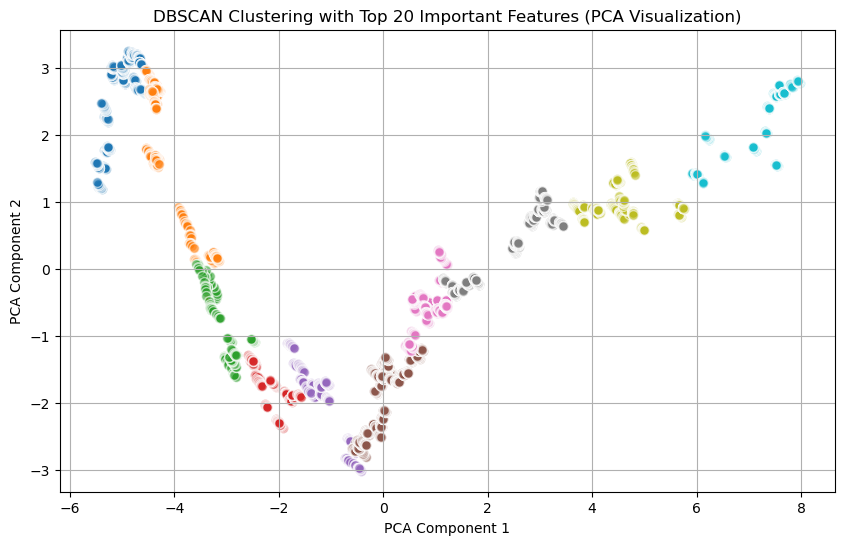

In [21]:
# 시각화 (PCA 결과를 기반으로 군집 시각화)
plt.figure(figsize=(10, 6))
unique_clusters = set(clusters)
colors = plt.cm.get_cmap('tab10', len(unique_clusters))

for cluster in unique_clusters:
    if cluster == -1:
        color = 'black'
        label = 'Outliers'
    else:
        color = colors(cluster)
        label = f'Cluster {cluster}'

    plt.scatter(data_pca[clusters == cluster, 0], data_pca[clusters == cluster, 1],
                s=50, c=[color], label=label, alpha=0.6, edgecolors='w')

plt.title('DBSCAN Clustering with Top 20 Important Features (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

In [22]:
# 실루엣 계수 계산
score = silhouette_score(X_selected_scaled, clusters)
print(f"실루엣 계수: {score:.3f}")

실루엣 계수: 0.669


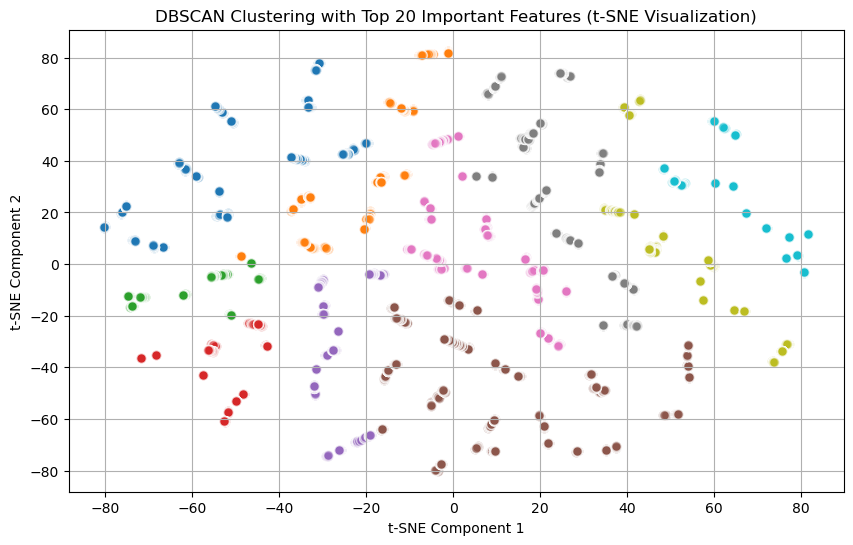

In [23]:
# t-SNE를 사용한 차원 축소 및 시각화
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(X_selected_scaled)

# 시각화 (t-SNE 결과 기반)
plt.figure(figsize=(10, 6))
for cluster in unique_clusters:
    cluster_data = data_tsne[clusters == cluster]
    if cluster == -1:
        color = 'black'
        label = 'Outliers'
    else:
        color = colors(cluster)
        label = f'Cluster {cluster}'

    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=50, c=[color], label=label, alpha=0.6, edgecolors='w')

plt.title('DBSCAN Clustering with Top 20 Important Features (t-SNE Visualization)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()


# 군집별 주요 변수의 평균값 및 통계량 분석
군집별 평균값을 비교하여 각 군집이 어떤 변수에서 높은 값 또는 낮은 값을 가지는지 파악.
히트맵을 통해 변수의 값을 시각적으로 비교하여, 군집 간의 특성을 한눈에 확인.

In [24]:
# 군집별 평균값 계산
df_selected = df_cleaned[selected_features]
df_selected['DBSCAN_Cluster'] = clusters

cluster_means = df_selected.groupby('DBSCAN_Cluster').mean()


# 군집별 주요 변수의 평균값을 전체 출력
display(cluster_means)

C:\Users\doing\AppData\Local\Temp\ipykernel_13432\2008011030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['DBSCAN_Cluster'] = clusters


,Government Debt,Core PCE Price Index,Core Consumer Prices,Wages,Corruption Rank,Price to Rent Ratio,Money Supply M0,Military Expenditure,Interbank Rate,Government Bond 10Y,Consumer Price Index CPI,GDP from Public Administration,Foreign Exchange Reserves,Mining Production,PCE Price Index,Pending Home Sales,Crude Oil Production,Disposable Personal Income,Foreign Direct Investment,Mortgage Originations
DBSCAN_Cluster,,,,,,,,,,,,,,,,,,,,
0,-1.425774,-1.544884,-1.482956,-1.517911,-1.101502,0.772177,-1.452673,-1.745347,0.562707,1.267218,-1.621185,-1.030634,-0.427462,-0.153608,-1.643093,0.836565,-1.000472,-1.457786,-1.167892,0.443195
1,-1.412718,-1.510738,-1.453386,-1.494404,-1.101502,0.829656,-1.451295,-1.745347,0.756648,1.247803,-1.562231,-1.027002,-0.778198,-0.125355,-1.607226,0.409096,-0.984924,-1.425007,-1.104864,0.403981
2,-1.397441,-1.482088,-1.432446,-1.456827,-1.101502,1.081357,-1.447646,-1.745347,1.010295,1.246005,-1.496673,-0.990623,-0.931519,-0.352538,-1.542075,0.463793,-1.099607,-1.384779,-1.320171,0.959668
3,-1.394074,-1.460445,-1.422288,-1.448374,-1.101502,1.081357,-1.444529,-1.745347,1.114640,1.225445,-1.395669,-0.990623,-1.037396,-1.129368,-1.446162,0.210667,-1.458415,-1.358677,-1.320171,0.959668
4,-1.371443,-1.419082,-1.383093,-1.411976,-1.101502,1.203281,-1.440370,-1.745347,1.348353,1.491070,-1.429153,-0.942537,-1.221971,-0.823725,-1.444630,-0.128832,-1.248948,-1.325610,-0.737978,1.135921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,1.382660,1.085344,1.065763,1.217925,2.022141,1.152403,1.762856,1.125363,-0.884815,-1.091350,1.000339,1.262842,-0.160767,-0.025658,1.018648,4.309356,1.064695,1.547273,2.403580,3.067713
90,1.385993,1.143302,1.128648,1.266560,2.022141,1.152403,1.762734,1.125363,-0.902266,-1.095417,1.075497,1.262842,-0.106333,1.894338,1.073500,1.209373,1.090267,1.406934,2.403580,3.067713
91,1.431320,1.192662,1.200540,1.303750,2.022141,1.152403,1.753638,1.125363,-0.914301,-1.187651,1.163293,1.262842,-0.297461,1.560926,1.128653,-0.029023,1.081743,1.407649,2.403580,3.067713


In [25]:
# 군집별 통계량 계산
cluster_stats = df_selected.groupby('DBSCAN_Cluster').describe()
display(cluster_stats)

Government Debt                                              \
                         count      mean           std       min       25%   
DBSCAN_Cluster                                                               
0                         62.0 -1.425774  7.862513e-03 -1.435909 -1.435909   
1                         67.0 -1.412718  3.836155e-03 -1.415443 -1.415443   
2                         44.0 -1.397441  2.724910e-03 -1.400260 -1.400260   
3                         22.0 -1.394074  4.545398e-16 -1.394074 -1.394074   
4                         65.0 -1.371443  8.071186e-03 -1.381123 -1.381123   
...                        ...       ...           ...       ...       ...   
89                        22.0  1.382660  6.818097e-16  1.382660  1.382660   
90                        21.0  1.385993  2.275280e-16  1.385993  1.385993   
91                        22.0  1.431320  0.000000e+00  1.431320  1.431320   
92                        66.0  1.417403  9.401357e-05  1.417311  1.417311   
93                        66.0  1.517186  4.668783e-02  1.483248  1.483248   

                                             Core PCE Price Index            \
                     50%       75%       max                count      mean   
DBSCAN_Cluster                                                                
0              -1.424195 -1.417144 -1.417144                 62.0 -1.544884   
1              -1.415314 -1.407273 -1.407273                 67.0 -1.510738   
2              -1.394867 -1.394867 -1.394867                 44.0 -1.482088   
3              -1.394074 -1.394074 -1.394074                 22.0 -1.460445   
4              -1.372179 -1.361467 -1.361467                 65.0 -1.419082   
...                  ...       ...       ...                  ...       ...   
89              1.382660  1.382660  1.382660                 22.0  1.085344   
90              1.385993  1.385993  1.385993                 21.0  1.143302   
91              1.431320  1.431320  1.431320                 22.0  1.192662   
92              1.417367  1.417531  1.417531                 66.0  1.270107   
93              1.483355  1.580538  1.580538                 66.0  1.412890   

                ... Foreign Direct Investment           Mortgage Originations  \
                ...                       75%       max                 count   
DBSCAN_Cluster  ...                                                             
0               ...                 -1.036827 -1.036827                  62.0   
1               ...                 -1.036827 -1.036827                  67.0   
2               ...                 -1.320171 -1.320171                  44.0   
3               ...                 -1.320171 -1.320171                  22.0   
4               ...                 -0.737978 -0.737978                  65.0   
...             ...                       ...       ...                   ...   
89              ...                  2.403580  2.403580                  22.0   
90              ...                  2.403580  2.403580                  21.0   
91              ...                  2.403580  2.403580                  22.0   
92              ...                  2.464153  2.464153                  66.0   
93              ...                  2.062917  2.062917                  66.0   

                                                                      \
                    mean           std       min       25%       50%   
DBSCAN_Cluster                                                         
0               0.443195  5.883631e-02  0.361650  0.361650  0.484962   
1               0.403981  5.899097e-02  0.361650  0.361650  0.361650   
2               0.959668  0.000000e+00  0.959668  0.959668  0.959668   
3               0.959668  1.136349e-16  0.959668  0.959668  0.959668   
4               1.135921  4.475452e-16  1.135921  1.135921  1.135921   
...                  ...           ...       ...       ...       ...   
89              3.067713  4.5453

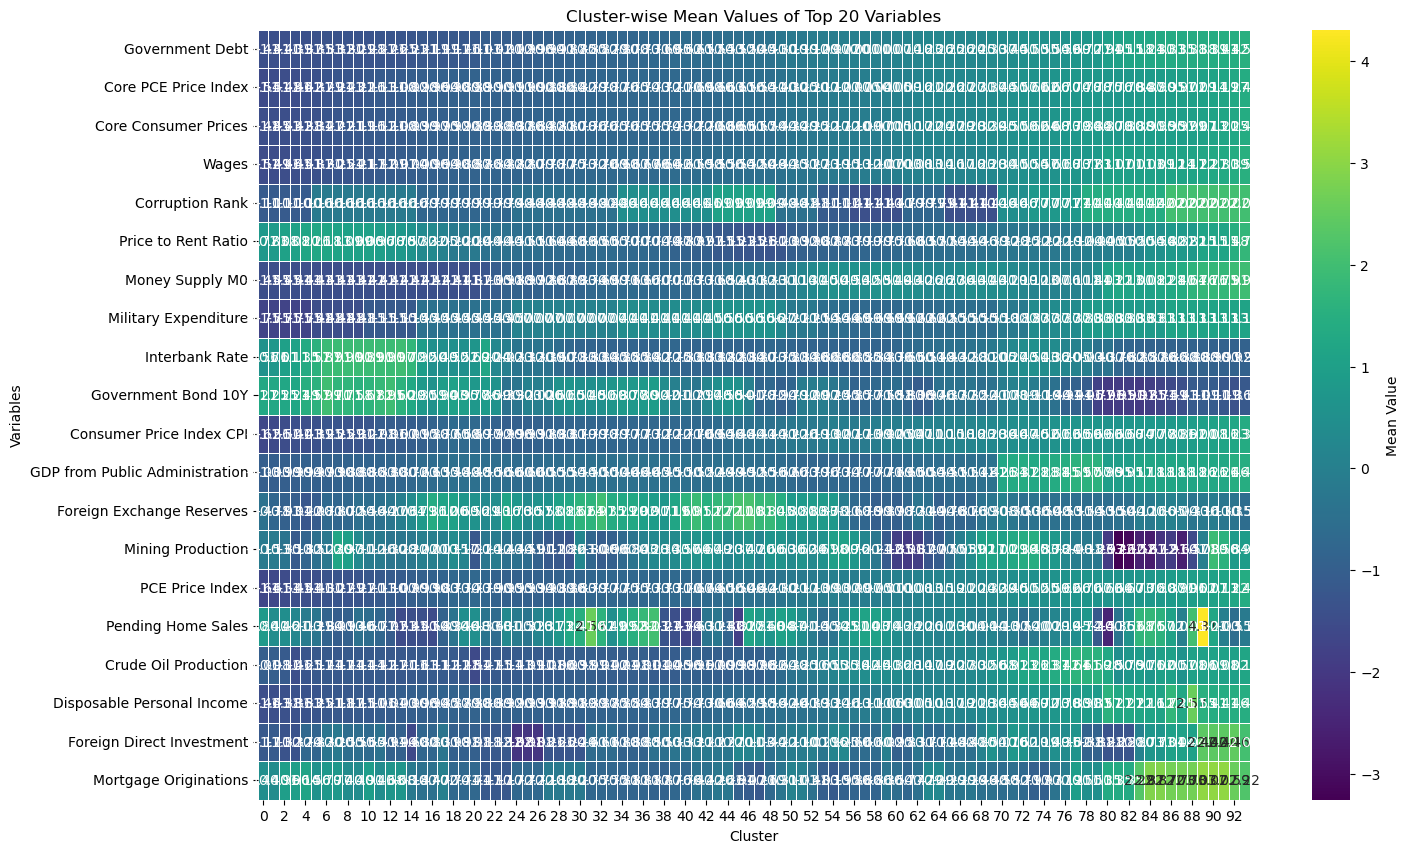

In [26]:
# 군집별 평균값 히트맵 시각화
plt.figure(figsize=(16, 10))
sns.heatmap(cluster_means.T, cmap='viridis', annot=True, fmt='.2f', linewidths=.5, cbar_kws={'label': 'Mean Value'})
plt.title('Cluster-wise Mean Values of Top 20 Variables')
plt.xlabel('Cluster')
plt.ylabel('Variables')
plt.show()

C:\Users\doing\AppData\Local\Temp\ipykernel_13432\2524377434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['USD'] = df_cleaned['USD']  # 원본 데이터프레임에서 'USD' 컬럼 추가


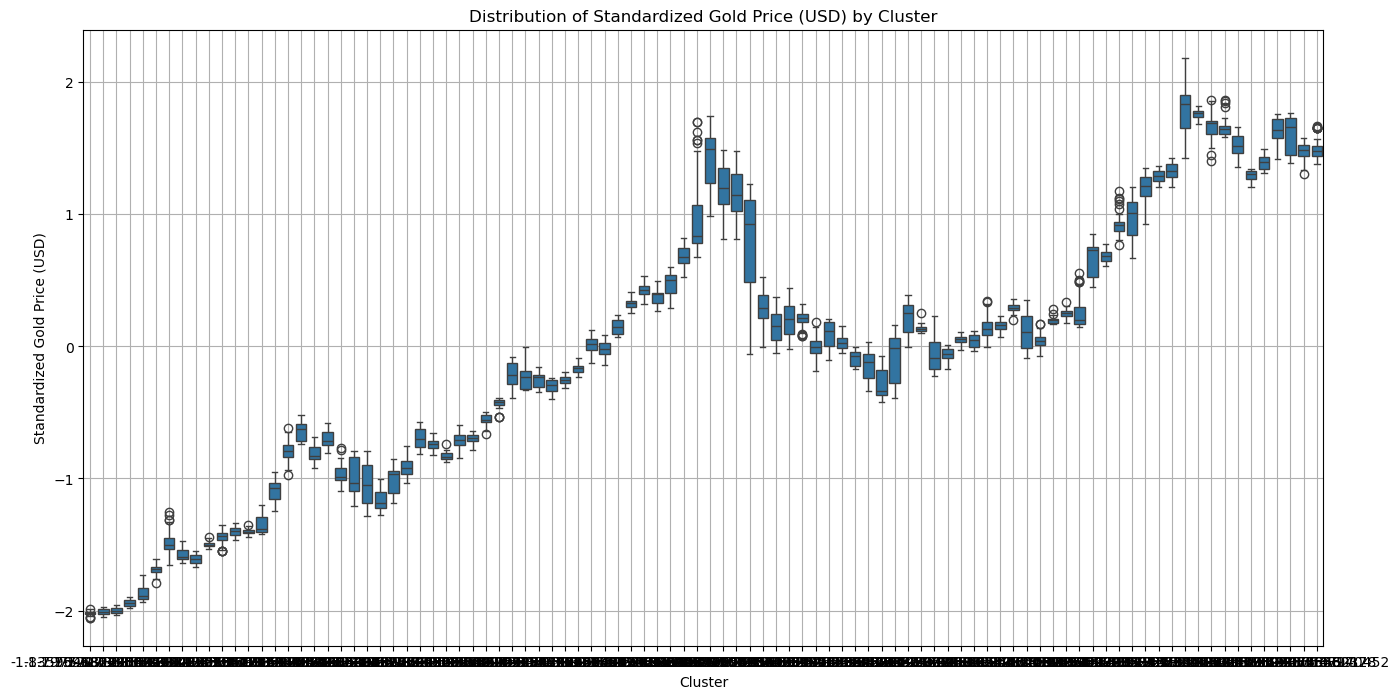

In [27]:
# 원본 데이터프레임에서 'USD' 컬럼을 추가하여 df_selected 데이터프레임 생성
df_selected['USD'] = df_cleaned['USD']  # 원본 데이터프레임에서 'USD' 컬럼 추가

# 표준화를 다시 수행
scaler = StandardScaler()
df_selected_scaled = scaler.fit_transform(df_selected)  # df_selected 전체에 대해 표준화 수행

# 표준화된 값을 데이터프레임으로 변환하여 컬럼명 유지
df_selected_scaled = pd.DataFrame(df_selected_scaled, columns=df_selected.columns)

# 박스플롯 시각화를 위해 표준화된 데이터프레임을 사용
plt.figure(figsize=(16, 8))
sns.boxplot(x='DBSCAN_Cluster', y='USD', data=df_selected_scaled)
plt.title('Distribution of Standardized Gold Price (USD) by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Standardized Gold Price (USD)')
plt.grid(True)
plt.show()

박스 플롯이나 히스토그램을 통해 군집별 변수의 분포를 확인하여, 각 군집이 해당 변수에서 어떤 특성을 가지는지 파악.
예를 들어, 금리나 주식시장 지수와 같은 변수의 값이 특정 군집에서 어떻게 분포되어 있는지를 시각적으로 확인.

c:\Users\doing\miniconda3\envs\ds_study\lib\site-packages\seaborn\distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  baselines[cols] = curves[cols].shift(1, axis=1).fillna(0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


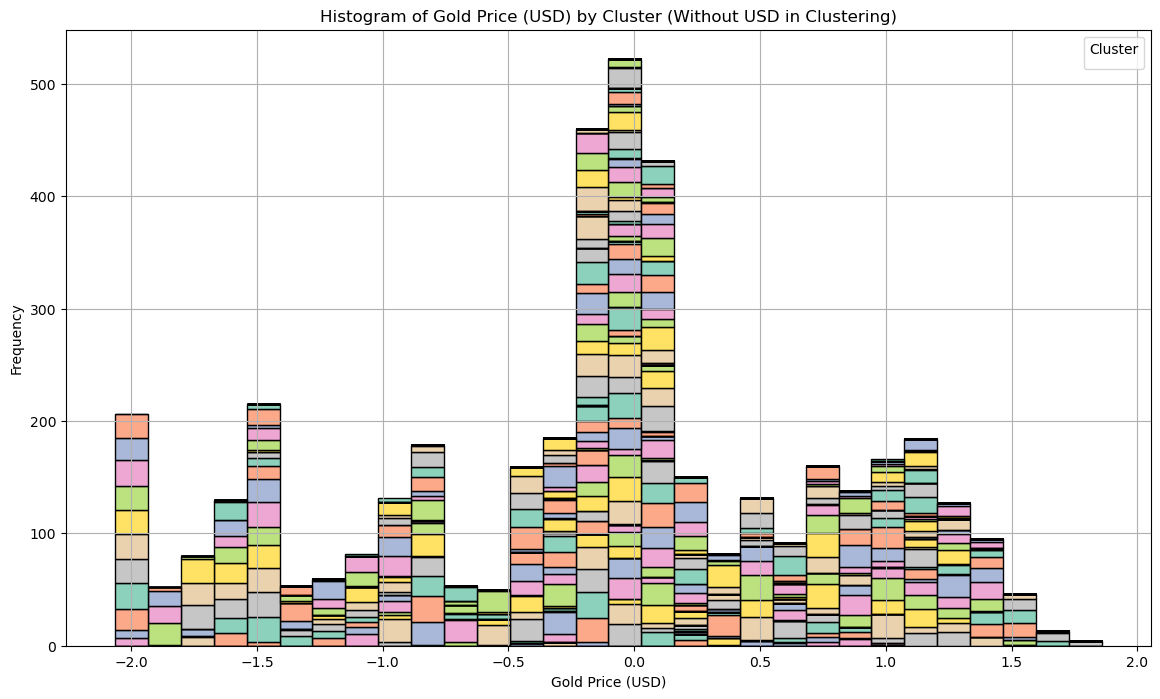

In [28]:
# USD를 제외한 데이터프레임 생성
df_without_usd = df_cleaned.drop(['USD'], axis=1)  # 'USD' 컬럼 제외

# 이터 표준화
scaler = StandardScaler()
df_without_usd_scaled = scaler.fit_transform(df_without_usd)

# DBSCAN 군집화 수행 (USD 제외한 데이터 사용)
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_without_usd = dbscan.fit_predict(df_without_usd_scaled)

# 군집화 결과를 원본 데이터프레임에 추가
df_cleaned['DBSCAN_Cluster_Without_USD'] = clusters_without_usd

# 군집별 USD 히스토그램 시각화
plt.figure(figsize=(14, 8))
sns.histplot(data=df_cleaned, x='USD', hue='DBSCAN_Cluster_Without_USD', multiple='stack', bins=30, palette='Set2')
plt.title('Histogram of Gold Price (USD) by Cluster (Without USD in Clustering)')
plt.xlabel('Gold Price (USD)')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


# 군집의 대표 데이터 포인트 찾기
각 군집의 **중심(centroid)**에 가장 가까운 데이터를 찾아서, 각 군집의 대표적인 데이터 포인트를 확인. 
이를 통해 각 군집의 대표적인 특성을 파악.

각 군집의 대표적인 데이터 포인트를 확인하여, 군집의 대표적인 특성을 이해하고 군집의 중심에 위치한 데이터가 어떤 특성을 가지는지 파악

In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances

In [30]:
# 1. 데이터프레임에서 숫자형 컬럼만 선택 (문자열 데이터 제외)
numeric_columns = df.select_dtypes(include=[np.number])  # 숫자형 컬럼만 선택

# 2. 혹시라도 비정상 값이나 NaN을 포함하는 컬럼이 있는지 확인하고 제거 또는 대체
numeric_columns = numeric_columns.replace('NaN', np.nan)  # NaN 문자열을 실제 NaN 값으로 변환
numeric_columns = numeric_columns.dropna()  # NaN 값을 포함하는 행 제거

# 'USD' 컬럼 제외한 데이터프레임 생성
if 'USD' in numeric_columns.columns:
    df_without_usd = numeric_columns.drop(['USD'], axis=1)  # 'USD' 제외한 숫자형 데이터만 사용
else:
    df_without_usd = numeric_columns  # 'USD' 컬럼이 없을 경우 그대로 사용

# 3. DBSCAN 군집화 수행
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(df_without_usd)

# 4. 군집별 대표 데이터 포인트 찾기 함수 정의
def find_representative_points(df, clusters):
    representative_points = {}
    for cluster_label in set(clusters):
        if cluster_label == -1:  # 노이즈 군집(-1)은 제외
            continue

        # 해당 군집의 데이터 선택
        cluster_data = df[clusters == cluster_label]

        # 군집 내 평균점(중심점) 계산
        cluster_mean = cluster_data.mean(axis=0)

        # 각 데이터와 평균점 사이의 거리 계산
        distances = pairwise_distances(cluster_data, cluster_mean.values.reshape(1, -1))

        # 가장 가까운 데이터 포인트의 인덱스를 찾음
        representative_index = np.argmin(distances)
        representative_points[cluster_label] = cluster_data.iloc[representative_index]

    return representative_points

# 5. 대표 데이터 포인트 찾기
representative_points = find_representative_points(df_without_usd, clusters)

# 6. 대표 데이터 포인트를 새로운 데이터프레임으로 저장
rep_points_df = pd.DataFrame(representative_points).T  # Transpose로 행과 열을 변환

# 7. 대표 데이터 포인트를 CSV 파일로 저장
rep_points_df.to_csv("representative_points.csv", index=True, encoding='utf-8-sig')
rep_points_df.to_json("representative_points.json", orient='records', lines=True, force_ascii=False)
print("대표 데이터 포인트가 'representative_points.csv' 파일로 저장되었음.")

대표 데이터 포인트가 'representative_points.csv' 파일로 저장되었음.


# 군집 간의 상관관계 분석
군집 간의 상관관계를 분석하여, 군집화된 데이터가 서로 어떤 관계를 가지는지 파악. 
예를 들어, 특정 변수(금리, 주식시장 지수 등)와 군집 결과 간의 상관관계를 확인.

상관관계 히트맵을 통해 군집 간의 변수들이 어떤 상관관계를 가지는지 확인.
예를 들어, 특정 군집이 주식시장 지수와 높은 상관관계를 가지는지, 금리와 인플레이션 간의 상관관계가 군집별로 어떻게 다른지 분석.

In [35]:
# 군집과 특정 변수 간의 상관관계 분석
correlation_matrix = df.groupby('DBSCAN_Cluster').mean().corr()
correlation_matrix.to_csv("correlation_matrix.csv", index=True, encoding='utf-8-sig')
correlation_matrix.to_json("correlation_matrix.json", orient='records', lines=True, force_ascii=False)
print("Correlation Matrix of Cluster-wise Mean Values:\n", correlation_matrix)

Correlation Matrix of Cluster-wise Mean Values:
                                    USD  Effective Federal Funds Rate  \
USD                           1.000000                     -0.665929   
Effective Federal Funds Rate -0.665929                      1.000000   
Government Bond 10Y          -0.871375                      0.694391   
Interbank Rate               -0.726349                      0.966107   
Interest Rate                -0.653038                      0.996075   
...                                ...                           ...   
Retirement Age Women          0.472633                     -0.209787   
Temperature                   0.351942                      0.015237   
Terrorism Index               0.369652                     -0.257625   
Weapons Sales                 0.719701                     -0.332525   
DBSCAN_Cluster_Without_USD    0.849488                     -0.485864   

                              Government Bond 10Y  Interbank Rate  \
USD              

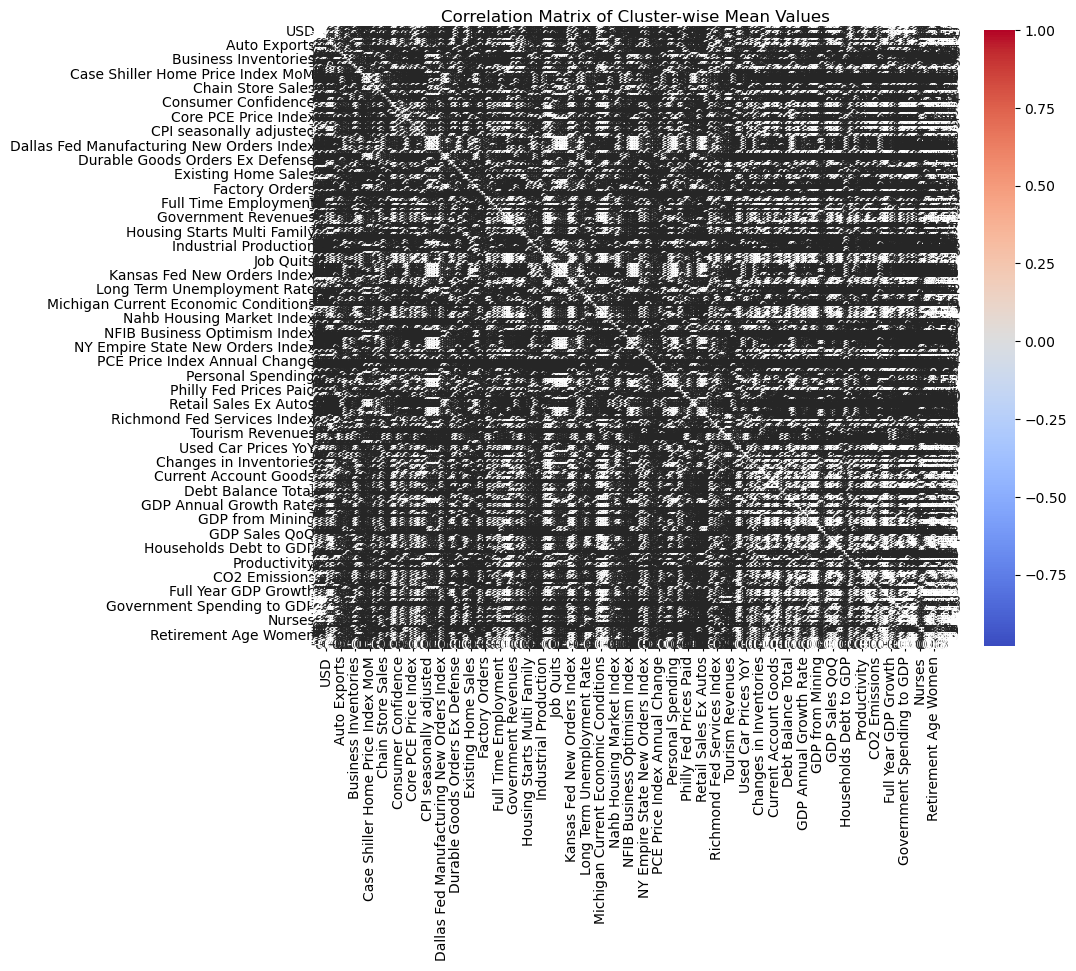

In [32]:
# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Cluster-wise Mean Values')
plt.show()

# 군집별로 라벨링 및 추가 해석
군집의 특성을 바탕으로 군집에 라벨을 부여하여, 군집에 대한 해석을 시도. 
예를 들어, 고객 데이터라면 "고가 상품 선호 고객", "가격 민감 고객" 등으로 군집을 명명.

각 군집의 특성에 따라 라벨을 부여하고, 각 군집이 어떤 특성을 가지는지 이해.
라벨을 부여한 후, 각 군집이 라벨에 맞게 잘 분포되어 있는지 시각적으로 확인.

In [39]:
# 1. 군집별 상위 20개 변수의 평균값 계산
top_20_features = [
    'Government Debt', 'Core PCE Price Index', 'Core Consumer Prices', 'Wages',
    'Corruption Rank', 'Price to Rent Ratio', 'Money Supply M0', 'Military Expenditure',
    'Interbank Rate', 'Government Bond 10Y', 'Consumer Price Index CPI', 'GDP from Public Administration',
    'Foreign Exchange Reserves', 'Mining Production', 'PCE Price Index', 'Pending Home Sales',
    'Crude Oil Production', 'Disposable Personal Income', 'Foreign Direct Investment', 'Mortgage Originations'
]

# 데이터프레임이 'df'에 있다고 가정하고 진행
# 군집별 평균값 계산 (상위 20개 변수만)
cluster_means_top_20 = df.groupby('DBSCAN_Cluster')[top_20_features].mean()

# 2. 라벨링 기준 함수 정의
def label_clusters_top_20(cluster_means):
    labels = {}
    for cluster in cluster_means.index:
        # 초기 라벨 설정
        label = ""
        
        # 각 변수의 평균값을 기준으로 라벨링 수행
        for feature in top_20_features:
            if cluster_means.loc[cluster, feature] > cluster_means[feature].mean():
                label += f"High {feature}, "
            else:
                label += f"Low {feature}, "

        # 마지막에 불필요한 ", " 제거
        label = label.rstrip(', ')
        
        # 최종 라벨 설정
        labels[cluster] = label
    return labels

# 3. 상위 20개 변수에 대한 라벨링 수행
cluster_labels_top_20 = label_clusters_top_20(cluster_means_top_20)
print("군집별 상위 20개 변수 라벨링 결과:\n", cluster_labels_top_20)

# 4. 라벨을 원본 데이터프레임에 추가
df['Cluster_Label_Top_20'] = df['DBSCAN_Cluster'].map(cluster_labels_top_20)

# 5. 라벨링된 데이터프레임 저장
df.to_csv("labeled_clustered_data_top_20_features.csv", index=False, encoding='utf-8-sig')
df.to_json("labeled_clustered_data_top_20_features.json", orient='records', lines=True, force_ascii=False)
print("상위 20개 변수로 라벨링된 군집 데이터가 'labeled_clustered_data_top_20_features.csv' 파일로 저장되었습니다.")

# 6. 라벨링된 데이터 확인
print(df[['DBSCAN_Cluster', 'Cluster_Label_Top_20']].drop_duplicates())

군집별 상위 20개 변수 라벨링 결과:
 {0: 'Low Government Debt, Low Core PCE Price Index, Low Core Consumer Prices, Low Wages, Low Corruption Rank, High Price to Rent Ratio, Low Money Supply M0, Low Military Expenditure, High Interbank Rate, High Government Bond 10Y, Low Consumer Price Index CPI, Low GDP from Public Administration, Low Foreign Exchange Reserves, High Mining Production, Low PCE Price Index, High Pending Home Sales, Low Crude Oil Production, Low Disposable Personal Income, Low Foreign Direct Investment, High Mortgage Originations', 1: 'Low Government Debt, Low Core PCE Price Index, Low Core Consumer Prices, Low Wages, Low Corruption Rank, High Price to Rent Ratio, Low Money Supply M0, Low Military Expenditure, High Interbank Rate, High Government Bond 10Y, Low Consumer Price Index CPI, Low GDP from Public Administration, Low Foreign Exchange Reserves, High Mining Production, Low PCE Price Index, High Pending Home Sales, Low Crude Oil Production, Low Disposable Personal Income, Low Fore

C:\Users\doing\AppData\Local\Temp\ipykernel_13432\50258639.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster_Label_Top_20', data=df, palette='Set2')


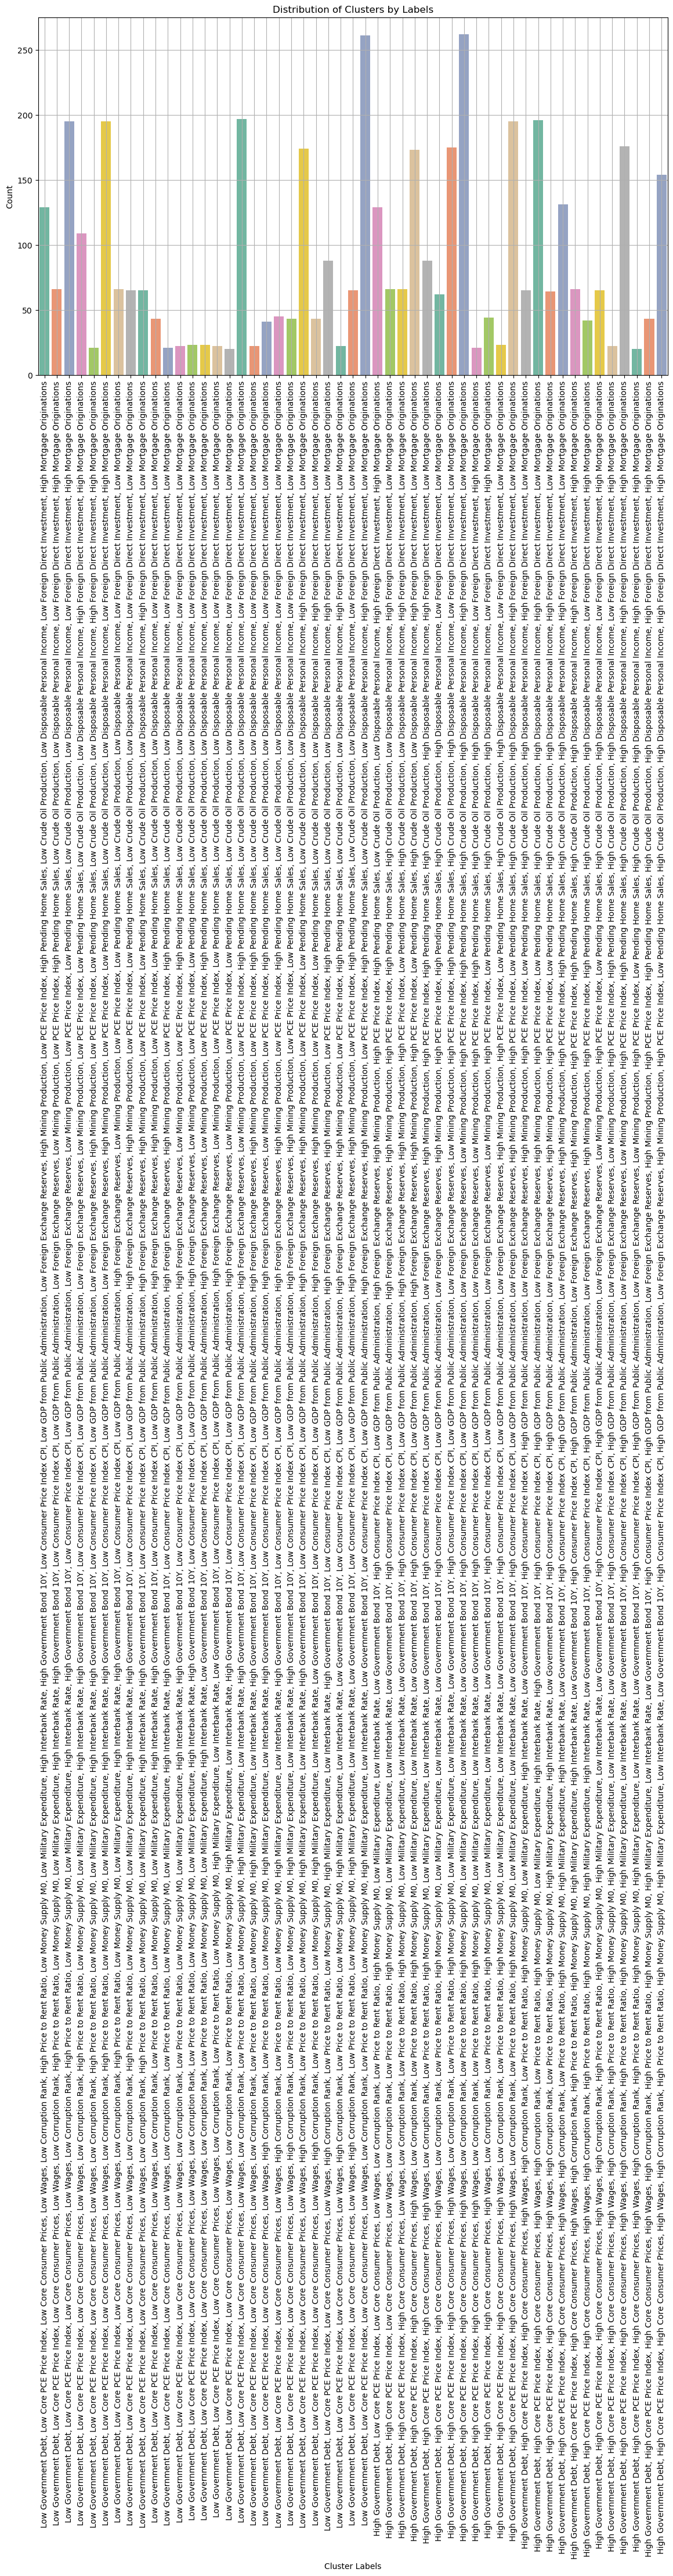

In [38]:
plt.figure(figsize=(14, 8))
sns.countplot(x='Cluster_Label_Top_20', data=df, palette='Set2')
plt.title('Distribution of Clusters by Labels')
plt.xlabel('Cluster Labels')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.grid(True)
plt.show()